## Problem statement

### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing all the important libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pathlib, os, PIL

import numpy as np, pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, preprocessing
from tensorflow.keras.models import Sequential

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-07-10 14:04:59.020319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 14:04:59.020447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 14:04:59.104402: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input
/kaggle/input/skin-cancer-dataset
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/vascular lesion
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/squamous cell carcinoma
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/basal cell carcinoma
/kaggle/input/skin-cancer-dataset/

## Importing Skin Cancer Data

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train Set:",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test Set:",image_count_test)

Train Set: 2239
Test Set: 118


## Creating dataset

In [4]:
# default image parameters
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [5]:
# train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
# validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# Listing out all the classes of skin cancer
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualizing data

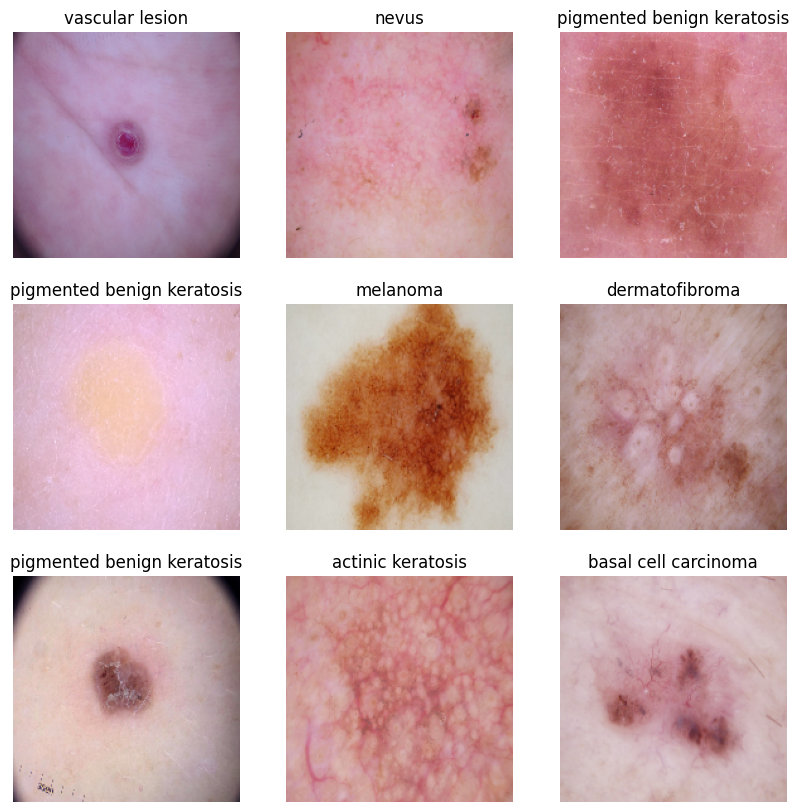

In [8]:
# visualizing each class
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds.take(1):
    print('Image Batch Shape:',image_batch.shape)
    print('Label Batch Shape:',labels_batch.shape)

Image Batch Shape: (32, 180, 180, 3)
Label Batch Shape: (32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [10]:
# keeping data ready in memory for processing
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

-1


## Modeling without Droputs

In [11]:
num_classes = len(class_names)
print("Number of Classes:",num_classes)

Number of Classes: 9


In [12]:
# defining model architecture
model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Nomalization to range [0,1]
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# compiling model
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
model_1.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# training the model
epochs = 20
model_1_history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
 9/56 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1231 - loss: 2.6521

I0000 00:00:1720620328.228565      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720620328.251120      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2114 - loss: 2.2347

W0000 00:00:1720620329.947970      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.2155 - loss: 2.2186 - val_accuracy: 0.3043 - val_loss: 1.8631
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3359 - loss: 1.8231 - val_accuracy: 0.3781 - val_loss: 1.6683
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3866 - loss: 1.6702 - val_accuracy: 0.4855 - val_loss: 1.5351
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4841 - loss: 1.4711 - val_accuracy: 0.4698 - val_loss: 1.5290
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4890 - loss: 1.4087 - val_accuracy: 0.5213 - val_loss: 1.4192
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5545 - loss: 1.2665 - val_accuracy: 0.4944 - val_loss: 1.4639
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5632 - loss: 1.2025 - val_accuracy: 0.5235 - val_loss: 1.4256
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6114 - loss: 1.1353 - val_accuracy: 0.5503 - val_loss: 1

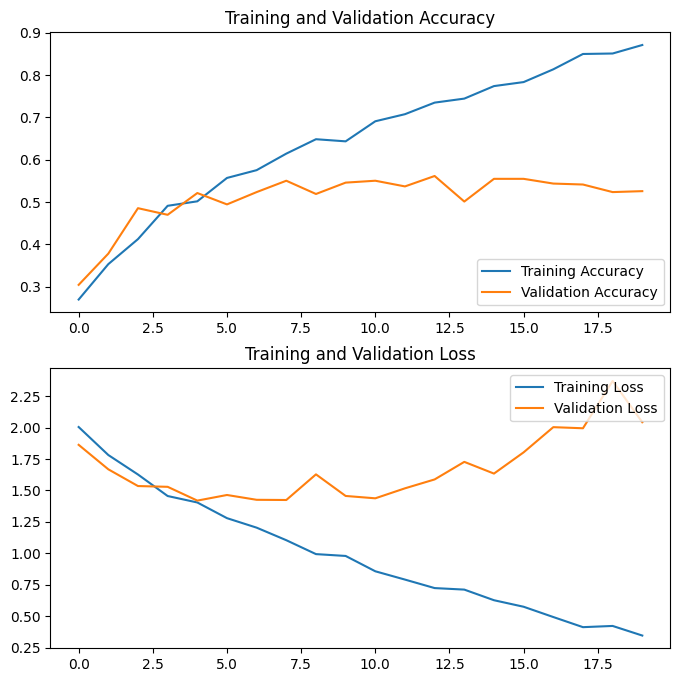

In [14]:
# visualizing the model performance
def model_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

model_performance(model_1_history) 

- The Training accuracy of model is esceptionally high as commpared to Validation accuracy. This suggests that there is some overfitting done by the model.
- The Training Loss of model is esceptionally low as commpared to Validation Loss. This also suggests that there is some overfitting done by the model.

## Modeling with Data Augumentation and Dropouts

In [15]:
# choosing an appropriate data augumentation strategy and building model
model_2 = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(factor=0.2),
    layers.RandomZoom(0.5, 0.2)
])

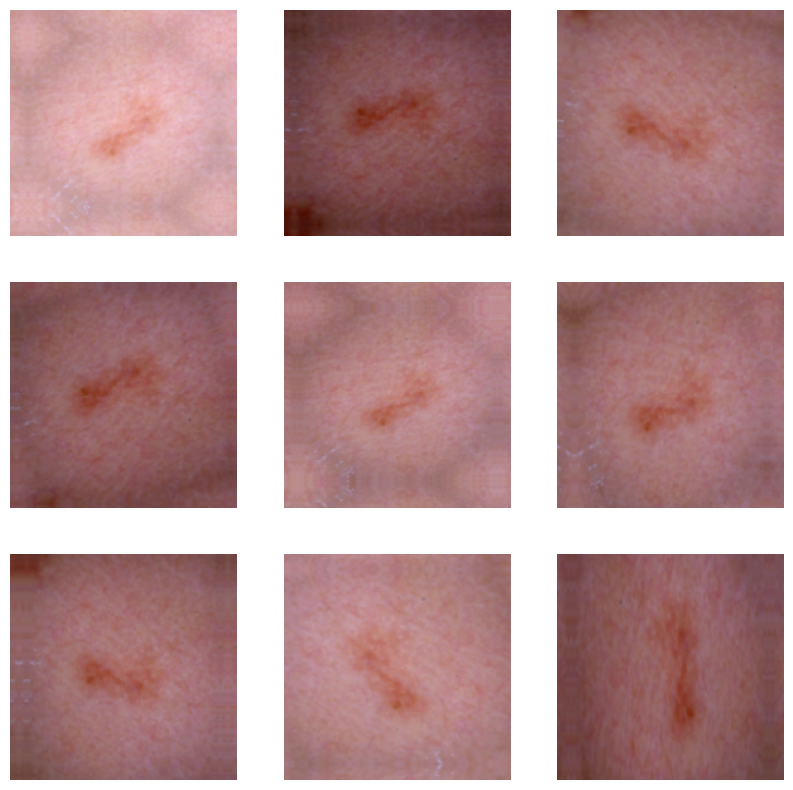

In [16]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = model_2(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [17]:
# building the rest model with droput layers
model_2.add(layers.Rescaling(1./255)),
model_2.add(layers.Conv2D(16, 3, padding='same', activation='relu')),
model_2.add(layers.MaxPooling2D()),
model_2.add(layers.Conv2D(32, 3, padding='same', activation='relu')),
model_2.add(layers.MaxPooling2D()),
model_2.add(layers.Conv2D(64, 3, padding='same', activation='relu')),
model_2.add(layers.MaxPooling2D()),
model_2.add(layers.Dropout(0.2)),
model_2.add(layers.Flatten()),
model_2.add(layers.Dense(128, activation='relu')),
model_2.add(layers.Dense(num_classes, name="outputs"))

# compiling the model
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# observing the model Summary
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 180, 180, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# training the model
model_2_history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2024-07-10 14:05:55.256757: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.2237 - loss: 2.0155 - val_accuracy: 0.3490 - val_loss: 1.7283
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4058 - loss: 1.6658 - val_accuracy: 0.4922 - val_loss: 1.4943
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4336 - loss: 1.5882 - val_accuracy: 0.4810 - val_loss: 1.4785
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4699 - loss: 1.4754 - val_accuracy: 0.5011 - val_loss: 1.5039
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4556 - loss: 1.4784 - val_accuracy: 0.5123 - val_loss: 1.4553
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4734 - loss: 1.4634 - val_accuracy: 0.4944 - val_loss: 1.4440
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4758 - loss: 1.4026 - val_accuracy: 0.5123 - val_loss: 1.4053
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5138 - loss: 1.3750 - val_accuracy: 0.5034 - val_loss: 1.

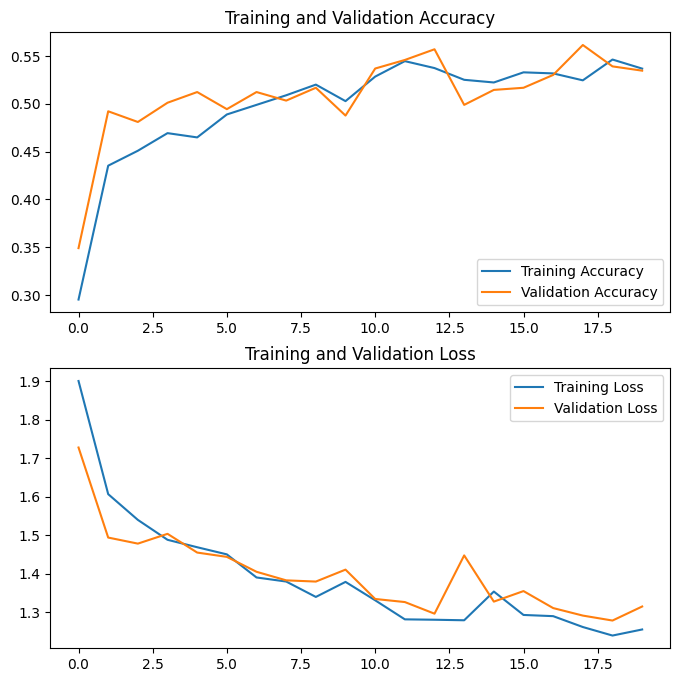

In [19]:
# Visualizing the results
model_performance(model_2_history)

- The Training accuracy is lower as compared to model 1
- The Testing accuracy and loss moves closer to Training accuracy, so model 2 is better than model 1 in some sense.
- The accuracy is very low so, we have to work on improving the results.

## Managing Class Imbalance

In [20]:
# Find the distribution of classes in the training dataset.
class_state = {}
for name in class_names:
    class_state[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

final_class_state = pd.DataFrame(class_state.items(), columns = ['Class', 'Count'])
print(final_class_state)

                        Class  Count
0           actinic keratosis    114
1        basal cell carcinoma    376
2              dermatofibroma     95
3                    melanoma    438
4                       nevus    357
5  pigmented benign keratosis    462
6        seborrheic keratosis     77
7     squamous cell carcinoma    181
8             vascular lesion    139


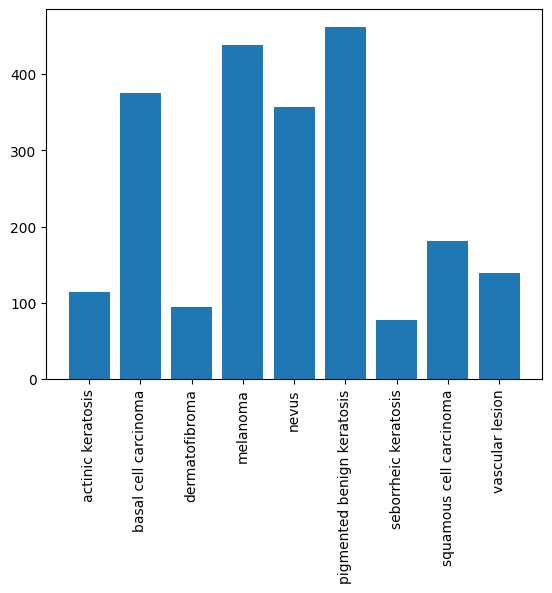

In [21]:
plt.bar(final_class_state.Class, final_class_state.Count)
plt.xticks(rotation=90)
plt.show()

Findings:
1. Which class has the least number of samples?
- Seborrheic Keratosis with only 58 samples in training data.

2. Which classes dominate the data in terms proportionate number of samples?
- Pigmented Benign Keratosis (370), Melanoma (352), Basal Cell Carcinoma (309), Nevus (277)

### Using Augmentor Library

In [22]:
!pip install Augmentor

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [23]:
path_to_training_dataset= "/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

import Augmentor
# augmenting images to each class
for classn in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+classn, output_directory='/kaggle/working/'+classn+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_random(probability=0.3)
    p.crop_random(probability=0.1, percentage_area=0.3)
    p.random_brightness(probability=0.5, min_factor=0.4, max_factor=0.9)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A20C21CA500>: 100%|██████████| 500/500 [00:06<00:00, 79.04 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A20C2217B20>: 100%|██████████| 500/500 [00:06<00:00, 77.38 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A20C218B130>: 100%|██████████| 500/500 [00:06<00:00, 75.90 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7A21081ED570>: 100%|██████████| 500/500 [00:34<00:00, 14.42 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=777x583 at 0x7A20C21AF0D0>: 100%|██████████| 500/500 [00:30<00:00, 16.21 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A2108260160>: 100%|██████████| 500/500 [00:06<00:00, 78.50 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A21204A9DE0>: 100%|██████████| 500/500 [00:15<00:00, 33.14 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A2120492230>: 100%|██████████| 500/500 [00:06<00:00, 80.20 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A212036E980>: 100%|██████████| 500/500 [00:07<00:00, 71.37 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [24]:
output_dir = pathlib.Path('/kaggle/working')
aug_image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print("Augumented Image Count:", aug_image_count_train)

Augumented Image Count: 4500


In [25]:
class_state = {}
for name in class_names:
    class_state[name] = len(list(output_dir.glob(name+'*/output/*.jpg')))
final_class_state = pd.DataFrame(class_state.items(), columns = ['Class', 'Count'])
final_class_state

Class  Count
0           actinic keratosis    500
1        basal cell carcinoma    500
2              dermatofibroma    500
3                    melanoma    500
4                       nevus    500
5  pigmented benign keratosis    500
6        seborrheic keratosis    500
7     squamous cell carcinoma    500
8             vascular lesion    500

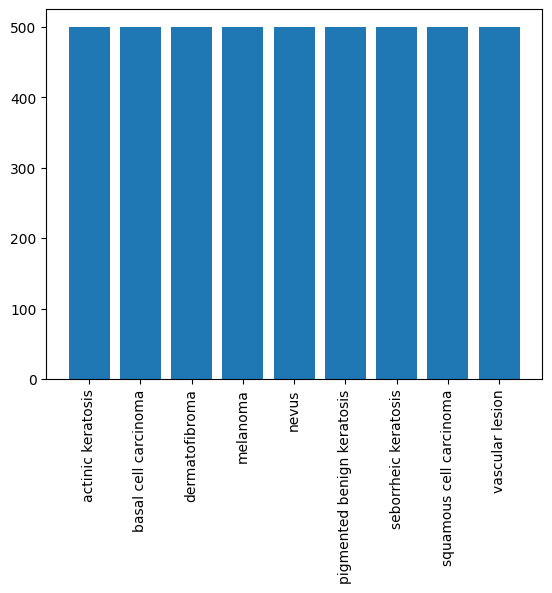

In [26]:
plt.bar(final_class_state.Class, final_class_state.Count)
plt.xticks(rotation=90)
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [27]:
# training data
train_aug_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [28]:
combined_train_data = train_ds.concatenate(train_aug_ds)
# total data count for validation set: 1792(initial) + 3600(augmented) = 5392(total)

In [29]:
# validation set
val_aug_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [30]:
combined_val_data = val_ds.concatenate(val_aug_ds)
# total data count for validation set: 447(initial) + 900(augmented) = 1347(total)
# total training data: 2239(initial) + 4500(augmented) =  6739(total) = 5392(combined train) + 1347(combined validation)

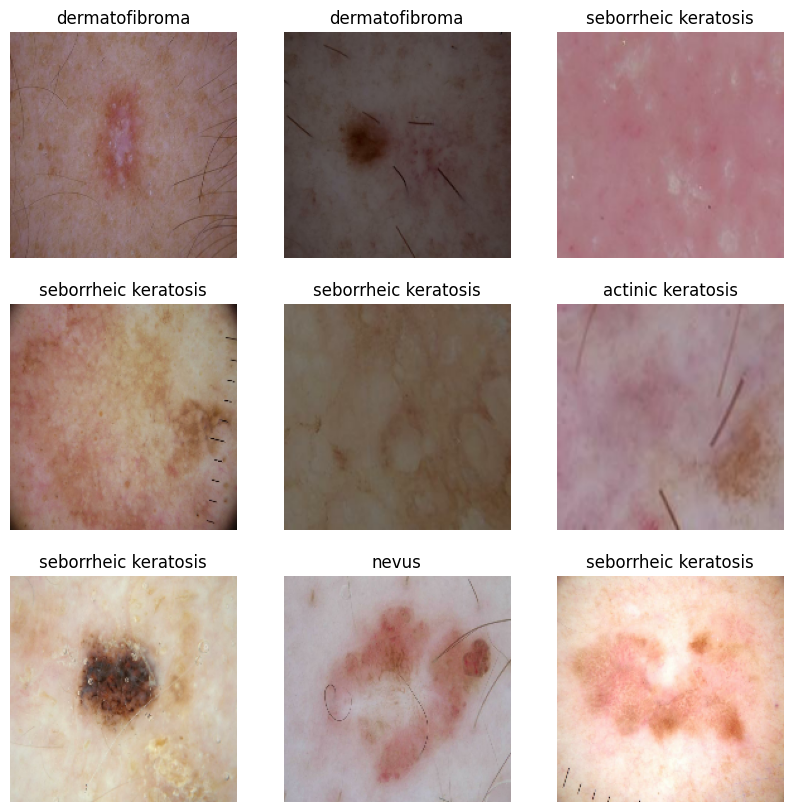

In [31]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, labels in train_aug_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
combined_train_data = train_aug_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
combined_val_data = val_aug_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
# defining model architecture
model_3 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

# compiling model
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

# model summary
model_3.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,990,249 (15.22 MB)

 Trainable params: 3,990,025 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

In [34]:
epochs = 30

# training model
model_3_history = model_3.fit(
  combined_train_data,
  validation_data=combined_val_data,
  epochs=epochs
)

Epoch 1/30
  8/113 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1459 - loss: 9.8972

W0000 00:00:1720620553.878077      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2080 - loss: 4.4271

W0000 00:00:1720620564.485623      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - accuracy: 0.2088 - loss: 4.3827 - val_accuracy: 0.1144 - val_loss: 15.8512
Epoch 2/30
 10/113 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3077 - loss: 1.8573

W0000 00:00:1720620565.855053      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3179 - loss: 1.7948 - val_accuracy: 0.1411 - val_loss: 21.0963
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3689 - loss: 1.6812 - val_accuracy: 0.1844 - val_loss: 14.5023
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3881 - loss: 1.5414 - val_accuracy: 0.2322 - val_loss: 5.7980
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4196 - loss: 1.4866 - val_accuracy: 0.3633 - val_loss: 2.0830
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4484 - loss: 1.4019 - val_accuracy: 0.3289 - val_loss: 1.7858
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4815 - loss: 1.3751 - val_accuracy: 0.3633 - val_loss: 1.8764
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5144 - loss: 1.2490 - val_accuracy: 0.3622 - val_loss: 1.8018
Epoch 9/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5296 - loss: 1.1625 - val_accuracy: 0.3

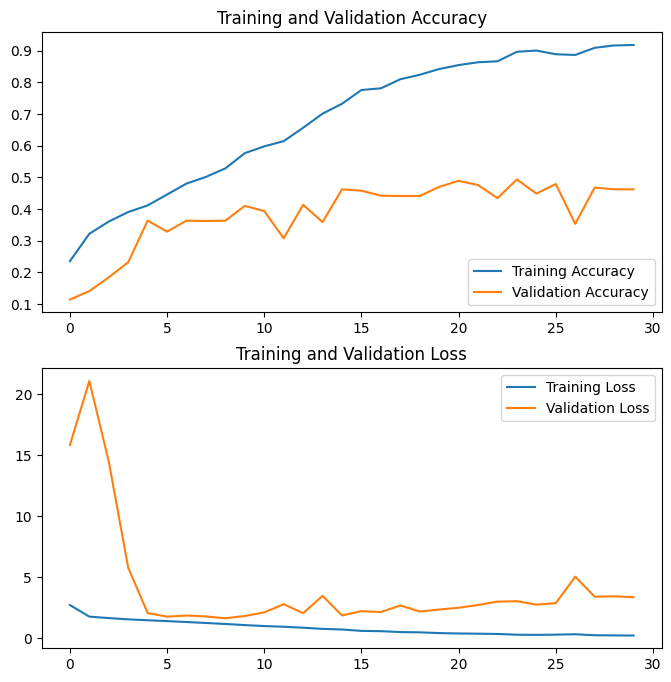

In [35]:
# visualizing the results
model_performance(model_3_history)

Findings:
- Still overfitting

In [36]:
# building the model with data agumentation and droput layers
model_4 = Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

# compiling model
model_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

# model summary
model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,990,249 (15.22 MB)

 Trainable params: 3,990,025 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

In [37]:
epochs = 30

# training model
model_4_history = model_4.fit(
  combined_train_data,
  validation_data=combined_val_data,
  epochs=epochs
)

Epoch 1/30


2024-07-10 14:10:37.207339: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/dropout_2_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.2100 - loss: 6.0080 - val_accuracy: 0.1056 - val_loss: 17.7306
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.2600 - loss: 1.9038 - val_accuracy: 0.1144 - val_loss: 25.4982
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.2910 - loss: 1.8155 - val_accuracy: 0.1722 - val_loss: 21.4366
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.3269 - loss: 1.7361 - val_accuracy: 0.2122 - val_loss: 10.6308
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.3292 - loss: 1.7299 - val_accuracy: 0.2611 - val_loss: 3.1555
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3250 - loss: 1.7229 - val_accuracy: 0.3378 - val_loss: 1.7695
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3463 - loss: 1.6582 - val_accuracy: 0.3011 - val_loss: 1.8568
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3431 - loss: 1.6851 - val_accuracy: 

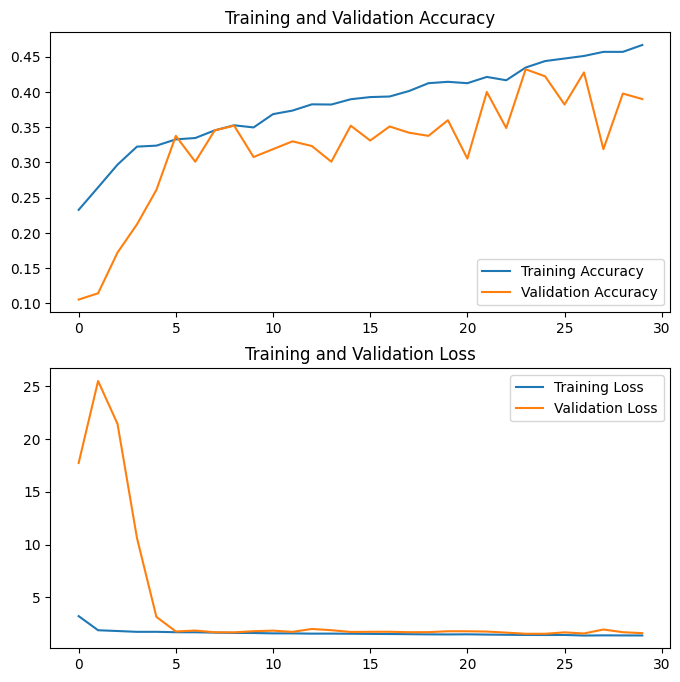

In [38]:
# visualizing the results
model_performance(model_4_history)

- Model is performed much better, need to improve accuracy

In [39]:
# building the model with more data augmentation
model_5 = Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.3),
  layers.RandomZoom(0.1),
  layers.RandomBrightness(factor=0.2),
  layers.RandomZoom(0.5, 0.2),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## your code goes here
model_5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

# model summary
model_5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_1             │ (None, 180, 180, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_4 (RandomZoom)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,990,249 (15.22 MB)

 Trainable params: 3,990,025 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

In [40]:
# more epochs
epochs = 50

# training model
model_5_history = model_5.fit(
  combined_train_data,
  validation_data=combined_val_data,
  epochs=epochs
)

Epoch 1/50


2024-07-10 14:13:19.132819: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.2030 - loss: 5.4562 - val_accuracy: 0.1167 - val_loss: 23.1088
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.2717 - loss: 1.9102 - val_accuracy: 0.1222 - val_loss: 21.1657
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3066 - loss: 1.8382 - val_accuracy: 0.1833 - val_loss: 17.0392
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3106 - loss: 1.7889 - val_accuracy: 0.2156 - val_loss: 5.0141
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3240 - loss: 1.7668 - val_accuracy: 0.2967 - val_loss: 2.1099
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.3212 - loss: 1.7317 - val_accuracy: 0.2811 - val_loss: 1.8459
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3303 - loss: 1.7212 - val_accuracy: 0.3078 - val_loss: 1.7190
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3465 - loss: 1.6975 - val_accuracy: 0.

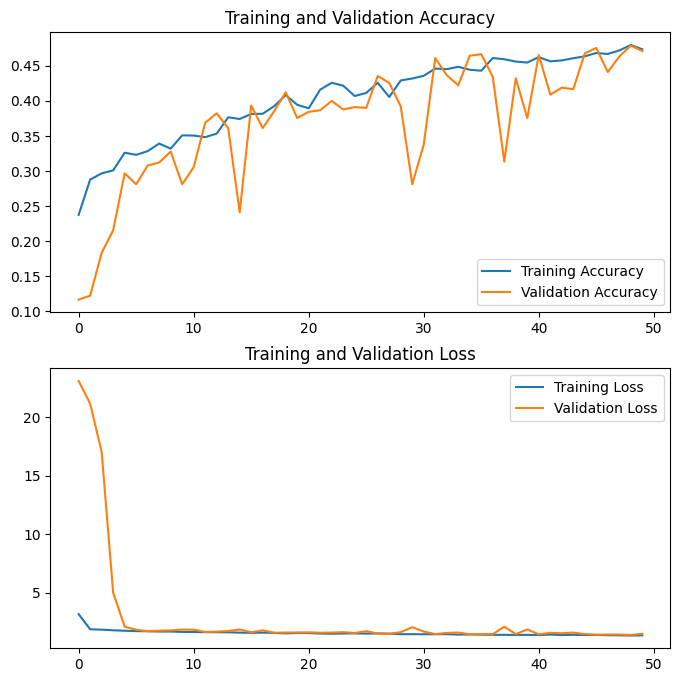

In [41]:
# visualizing the results
model_performance(model_5_history)

- model still needs to be improved, but overfitting is not visible

In [42]:
# building the model adding more droput layers
model_6 = Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.3),
  layers.RandomZoom(0.1),
  layers.RandomBrightness(factor=0.2),
  layers.RandomZoom(0.5, 0.2),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## your code goes here
model_6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

model_6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_5 (RandomZoom)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_2             │ (None, 180, 180, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_6 (RandomZoom)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 15488)          │             

 Total params: 2,082,153 (7.94 MB)

 Trainable params: 2,081,673 (7.94 MB)

 Non-trainable params: 480 (1.88 KB)

In [43]:
epochs = 50

# training model
model_6_history = model_6.fit(
  combined_train_data,
  validation_data=combined_val_data,
  epochs=epochs
)

Epoch 1/50


2024-07-10 14:18:00.854375: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_5_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.1871 - loss: 4.8134 - val_accuracy: 0.1922 - val_loss: 2.4827
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.2857 - loss: 1.8914 - val_accuracy: 0.2378 - val_loss: 3.8831
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.3192 - loss: 1.7425 - val_accuracy: 0.2844 - val_loss: 1.8171
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3027 - loss: 1.7747 - val_accuracy: 0.3133 - val_loss: 1.7856
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3332 - loss: 1.6946 - val_accuracy: 0.3222 - val_loss: 1.7054
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3351 - loss: 1.6816 - val_accuracy: 0.3233 - val_loss: 1.6458
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3253 - loss: 1.7002 - val_accuracy: 0.2800 - val_loss: 1.8808
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3282 - loss: 1.6279 - val_accuracy: 0.3

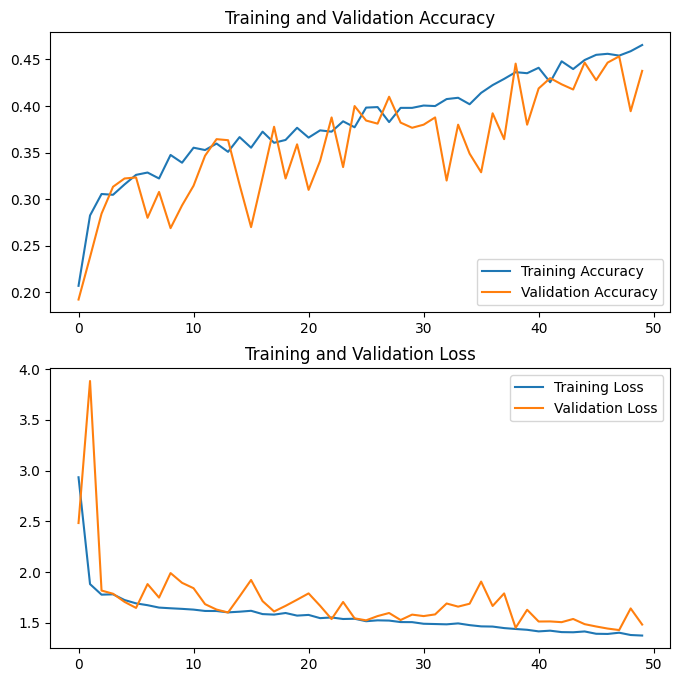

In [44]:
# visualizing the results
model_performance(model_6_history)

- Model is a good model but accuracy needs improvement

In [45]:
# building the model reducing droput layers and making it deeper
model_7 = Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## your code goes here
model_7.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

model_7.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_4               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_7 (RandomZoom)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6400)           │             

 Total params: 2,067,305 (7.89 MB)

 Trainable params: 2,066,313 (7.88 MB)

 Non-trainable params: 992 (3.88 KB)

In [46]:
epochs = 50

# training model
model_7_history = model_7.fit(
  combined_train_data,
  validation_data=combined_val_data,
  epochs=epochs
)

Epoch 1/50


2024-07-10 14:23:20.470517: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_6_1/dropout_8_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.2100 - loss: 2.5628 - val_accuracy: 0.1067 - val_loss: 2.8713
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3632 - loss: 1.7035 - val_accuracy: 0.1078 - val_loss: 3.0714
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3825 - loss: 1.5884 - val_accuracy: 0.0933 - val_loss: 3.7500
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.4048 - loss: 1.5236 - val_accuracy: 0.1522 - val_loss: 2.6637
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.4348 - loss: 1.4517 - val_accuracy: 0.3022 - val_loss: 1.7519
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.4612 - loss: 1.3972 - val_accuracy: 0.3400 - val_loss: 1.7706
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.4709 - loss: 1.3979 - val_accuracy: 0.4111 - val_loss: 1.5631
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.4819 - loss: 1.3494 - val_accuracy: 0.38

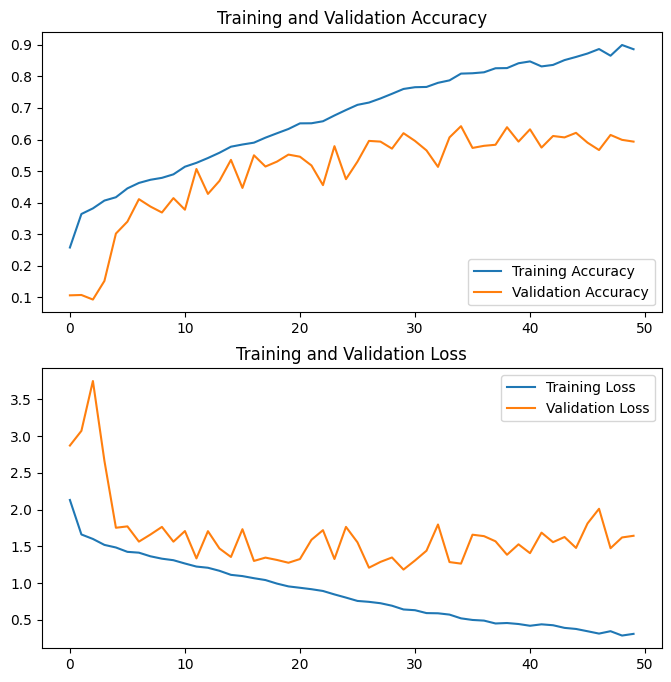

In [47]:
# visualizing the results
model_performance(model_7_history)

- Model gives more accuracy but overfits

In [48]:
# building the model reduced to only 1 dropout layer
model_8 = Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.3),
  layers.RandomZoom(0.1),
  layers.RandomBrightness(factor=0.2),
  layers.RandomZoom(0.5, 0.2),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## your code goes here
model_8.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

model_8.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_5 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_5               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_8 (RandomZoom)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_3             │ (None, 180, 180, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_9 (RandomZoom)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,067,305 (7.89 MB)

 Trainable params: 2,066,313 (7.88 MB)

 Non-trainable params: 992 (3.88 KB)

In [49]:
epochs = 50

# training model
model_8_history = model_8.fit(
  combined_train_data,
  validation_data=combined_val_data,
  epochs=epochs
)

Epoch 1/50


2024-07-10 14:28:35.177518: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_7_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.2330 - loss: 2.6105 - val_accuracy: 0.1011 - val_loss: 3.8402
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3006 - loss: 1.8076 - val_accuracy: 0.1011 - val_loss: 6.8019
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3187 - loss: 1.7293 - val_accuracy: 0.1300 - val_loss: 4.3447
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3240 - loss: 1.6793 - val_accuracy: 0.2111 - val_loss: 2.5737
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.3679 - loss: 1.6317 - val_accuracy: 0.3467 - val_loss: 1.6678
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.3814 - loss: 1.5715 - val_accuracy: 0.3267 - val_loss: 1.6883
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.3942 - loss: 1.5795 - val_accuracy: 0.3000 - val_loss: 2.0201
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.3845 - loss: 1.5563 - val_accuracy: 0.41

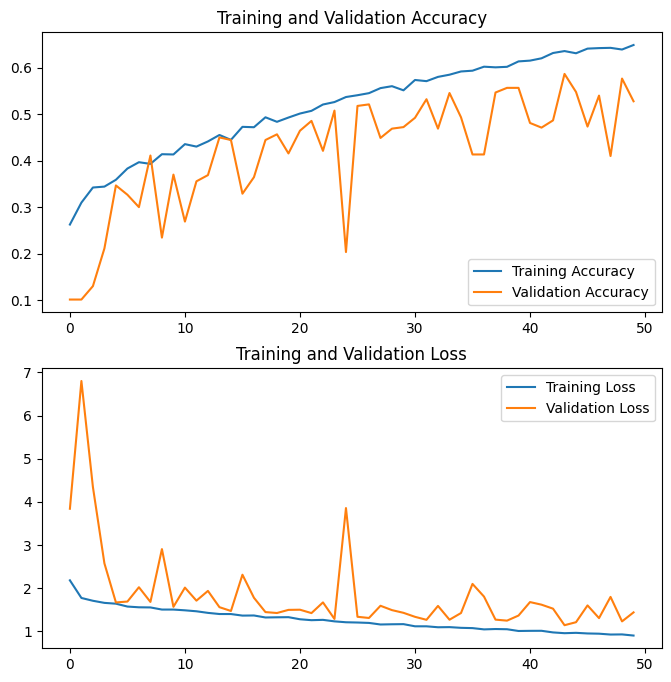

In [50]:
# visualizing the results
model_performance(model_8_history)

- Model achived a good accuracy in both vaildation and training

In [51]:
# building the model reduced normalization and added dropouts
model_9 = Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.3),
  layers.RandomZoom(0.1),
  layers.RandomBrightness(factor=0.2),
  layers.RandomZoom(0.5, 0.2),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## your code goes here
model_9.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

model_9.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_6 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_6               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_10 (RandomZoom)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_4             │ (None, 180, 180, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_11 (RandomZoom)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,89

 Total params: 2,066,473 (7.88 MB)

 Trainable params: 2,065,897 (7.88 MB)

 Non-trainable params: 576 (2.25 KB)

In [52]:
epochs = 100

# training model
model_9_history = model_9.fit(
  combined_train_data,
  validation_data=combined_val_data,
  epochs=epochs
)

Epoch 1/100


2024-07-10 14:33:47.044279: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_8_1/dropout_11_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.1677 - loss: 2.5849 - val_accuracy: 0.1200 - val_loss: 3.3860
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.3078 - loss: 1.8116 - val_accuracy: 0.1100 - val_loss: 3.2122
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.3293 - loss: 1.6783 - val_accuracy: 0.1644 - val_loss: 2.6008
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.3398 - loss: 1.6396 - val_accuracy: 0.1433 - val_loss: 2.2959
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.3719 - loss: 1.5932 - val_accuracy: 0.2478 - val_loss: 1.9918
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.3708 - loss: 1.5691 - val_accuracy: 0.3733 - val_loss: 1.5989
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.3956 - loss: 1.5443 - val_accuracy: 0.3600 - val_loss: 1.6326
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4045 - loss: 1.5274 - val_accuracy

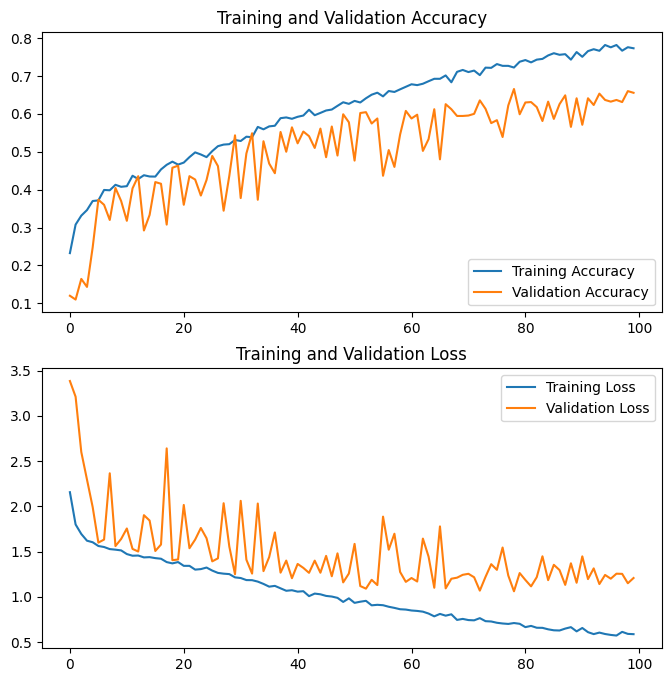

In [53]:
# visualizing the results
model_performance(model_9_history)

- there might be slight overfitting but it is a good model

In [54]:
# building the model 8 again to try with more iterations
model_10 = Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.3),
  layers.RandomZoom(0.1),
  layers.RandomBrightness(factor=0.2),
  layers.RandomZoom(0.5, 0.2),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## your code goes here
model_10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

model_10.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_7 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_7               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_12 (RandomZoom)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_5             │ (None, 180, 180, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_13 (RandomZoom)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,067,305 (7.89 MB)

 Trainable params: 2,066,313 (7.88 MB)

 Non-trainable params: 992 (3.88 KB)

In [55]:
epochs = 100

# training model
model_10_history = model_10.fit(
  combined_train_data,
  validation_data=combined_val_data,
  epochs=epochs
)

Epoch 1/100


2024-07-10 14:41:11.389284: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_9_1/dropout_13_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.2185 - loss: 2.5910 - val_accuracy: 0.1011 - val_loss: 3.9600
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.2876 - loss: 1.8149 - val_accuracy: 0.1256 - val_loss: 4.0049
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.3294 - loss: 1.6837 - val_accuracy: 0.1722 - val_loss: 3.0182
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.3568 - loss: 1.6317 - val_accuracy: 0.1567 - val_loss: 3.0432
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.3861 - loss: 1.5614 - val_accuracy: 0.2689 - val_loss: 2.0069
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.3741 - loss: 1.6023 - val_accuracy: 0.2878 - val_loss: 2.0702
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.3960 - loss: 1.5506 - val_accuracy: 0.3300 - val_loss: 1.9744
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.4067 - loss: 1.5318 - val_accurac

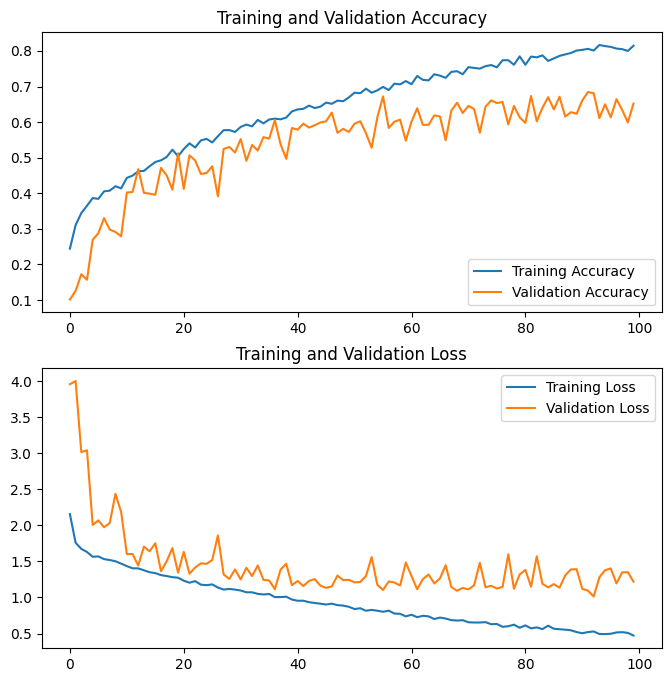

In [56]:
# visualizing the results
model_performance(model_10_history)

- The best model

In [57]:
# building the model 10 with adding one more normalization 
model_11 = Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.3),
  layers.RandomZoom(0.1),
  layers.RandomBrightness(factor=0.2),
  layers.RandomZoom(0.5, 0.2),
  layers.Rescaling(1./255),
  layers.BatchNormalization(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## your code goes here
model_11.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

# model summary
model_11.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_8 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_8               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_14 (RandomZoom)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_6             │ (None, 180, 180, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_15 (RandomZoom)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 180, 180, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 2,067,317 (7.89 MB)

 Trainable params: 2,066,319 (7.88 MB)

 Non-trainable params: 998 (3.90 KB)

In [58]:
epochs = 100

# training model
model_11_history = model_11.fit(
  combined_train_data,
  validation_data=combined_val_data,
  epochs=epochs
)

Epoch 1/100


2024-07-10 14:51:28.495436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_10_1/dropout_14_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.2156 - loss: 2.6049 - val_accuracy: 0.1067 - val_loss: 2.5649
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.2814 - loss: 1.9181 - val_accuracy: 0.1044 - val_loss: 2.3966
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.3088 - loss: 1.7908 - val_accuracy: 0.2511 - val_loss: 1.9260
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.3513 - loss: 1.6907 - val_accuracy: 0.3700 - val_loss: 1.6585
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.3689 - loss: 1.6081 - val_accuracy: 0.3967 - val_loss: 1.5722
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.3932 - loss: 1.5662 - val_accuracy: 0.3689 - val_loss: 1.6427
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.3982 - loss: 1.5349 - val_accuracy: 0.3911 - val_loss: 1.5471
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.3970 - loss: 1.5385 - val_accurac

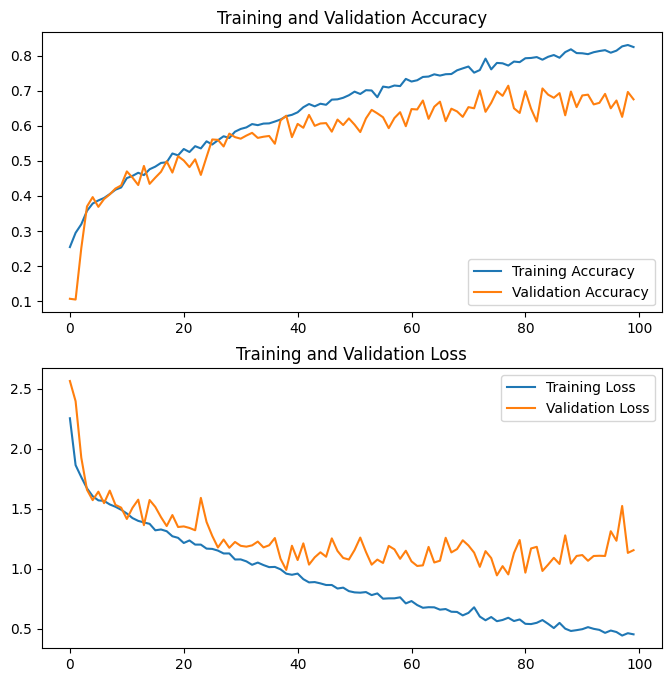

In [59]:
# visualizing the results
model_performance(model_11_history)

- this gives best results so far

## Evaluation on Test set

In [60]:
# train dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [61]:
# keeping data ready in memory for processing
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

-1


In [62]:
# visualizing how your augmentation strategy works for one instance of training image.
for images, labels in test_ds:
    score = model_11.evaluate(images, labels)
    print('Test Loss:', score[0])
    print('Test Accuracy', score[1])
    print('\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4375 - loss: 3.7802
Test Loss: 3.78017520904541
Test Accuracy 0.4375


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4375 - loss: 4.7215
Test Loss: 4.721510410308838
Test Accuracy 0.4375


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4688 - loss: 4.8422
Test Loss: 4.842215061187744
Test Accuracy 0.46875


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step - accuracy: 0.5455 - loss: 5.3062
Test Loss: 5.306192874908447
Test Accuracy 0.5454545617103577




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


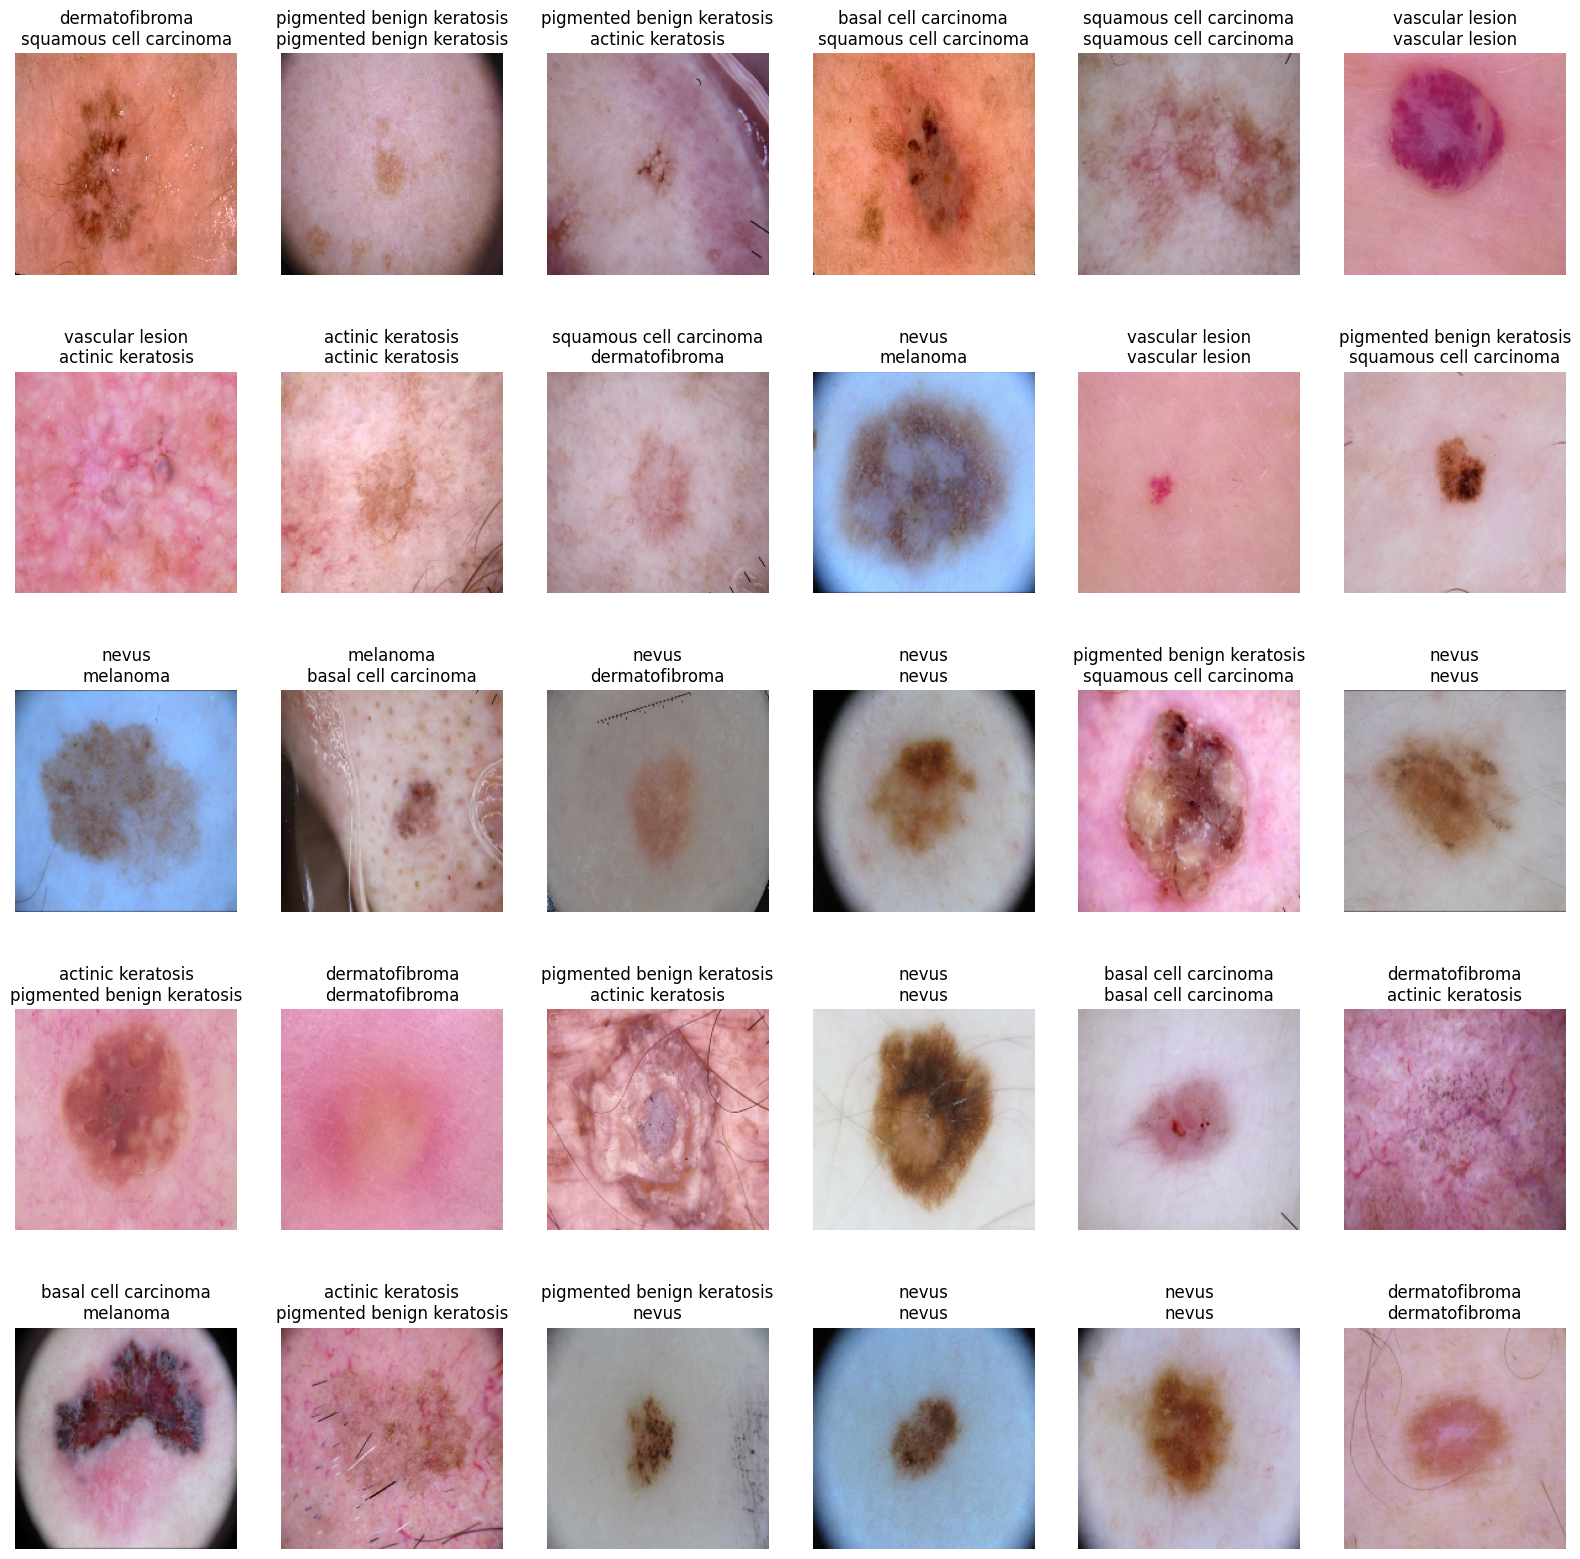

In [63]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model_11.predict(image_batch)

# Apply a sigmoid since our model returns logits


plt.figure(figsize=(20, 20))
for i in range(30):
    score = tf.nn.softmax(predictions[i])
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[np.argmax(score)] + "\n" + class_names[label_batch[i]])
    plt.axis("off")